<a href="https://colab.research.google.com/github/matheusfigueiredoo/detection-of-cyber-attacks/blob/main/bin_legitimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train = pd.read_csv("drive/MyDrive/MQTTset/train70_augmented.csv", nrows=5000000)
test = pd.read_csv("drive/MyDrive/MQTTset/test30_augmented.csv", nrows=3000000)
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [3]:
# distribuição das targets
print("Train: \n", train['target'].value_counts(), "\n")
print("Test: \n", test['target'].value_counts())

Train: 
 target
legitimate    2499426
malformed      500978
bruteforce     500848
slowite        500570
flood          499314
dos            498864
Name: count, dtype: int64 

Test: 
 target
legitimate    1499770
dos            300558
slowite        300371
flood          300107
malformed      299830
bruteforce     299364
Name: count, dtype: int64


In [4]:
# divisão de nomes das targets para legitimate e malicious

for i in train.index:
    if train['target'][i] != 'legitimate':
        train.at[i, 'target'] = 'malicious'
for i in test.index:
    if test['target'][i] != 'legitimate':
        test.at[i, 'target'] = 'malicious'

# nova distribuição das targets

print("Train: \n", train['target'].value_counts(), "\n")
print("Test: \n", test['target'].value_counts(), "\n")

Train: 
 target
malicious     2500574
legitimate    2499426
Name: count, dtype: int64 

Test: 
 target
malicious     1500230
legitimate    1499770
Name: count, dtype: int64 



In [5]:
# pre processamento de dados
# separacao de features e targets

X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]
y_train = train['target']
y_test = test['target']

In [6]:
# transformacao de targets categoricas em numeros inteiros

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# features
X_train['tcp.flags'] = label.fit_transform(X_train['tcp.flags'])
X_train['mqtt.conack.flags'] = label.fit_transform(X_train['mqtt.conack.flags'])
X_train['mqtt.hdrflags'] = label.fit_transform(X_train['mqtt.hdrflags'])
X_train['mqtt.protoname'] = label.fit_transform(X_train['mqtt.protoname'])
X_train['mqtt.msg'] = label.fit_transform(X_train['mqtt.msg'])
X_train['mqtt.conflags'] = label.fit_transform(X_train['mqtt.conflags'])

X_test['tcp.flags'] = label.fit_transform(X_test['tcp.flags'])
X_test['mqtt.conack.flags'] = label.fit_transform(X_test['mqtt.conack.flags'])
X_test['mqtt.hdrflags'] = label.fit_transform(X_test['mqtt.hdrflags'])
X_test['mqtt.protoname'] = label.fit_transform(X_test['mqtt.protoname'])
X_test['mqtt.msg'] = label.fit_transform(X_test['mqtt.msg'])
X_test['mqtt.conflags'] = label.fit_transform(X_test['mqtt.conflags'])

# targets
label.fit(y_train)
label.fit(y_test)
y_train = label.transform(y_train)
y_test = label.transform(y_test)

In [7]:
# ajuste de dados

# columns_0 são as colunas com dados iguais a 0

columns_0 = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos',
           'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag',
           'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len',
           'mqtt.willtopic', 'mqtt.willtopic_len']

X_train = X_train.drop(columns_0, axis=1)
X_test = X_test.drop(columns_0, axis=1)


print(X_train.shape)
print(X_test.shape)

(5000000, 20)
(3000000, 20)


In [8]:
X_train = X_train.values
X_test = X_test.values

print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None)
clf.fit(X_train, y_train)
print("Accuracy train: {}".format(clf.score(X_train, y_train)))
print("Accuracy test: {}".format(clf.score(X_test, y_test)))

Accuracy train: 0.9604186
Accuracy test: 0.96069


In [10]:
# predição de valores

predict = clf.predict(X_test)

# metrics

from sklearn.metrics import classification_report

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96   1499770
           1       0.98      0.94      0.96   1500230

    accuracy                           0.96   3000000
   macro avg       0.96      0.96      0.96   3000000
weighted avg       0.96      0.96      0.96   3000000



In [11]:
# confusion matrix

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predict)
print(matrix)

[[1477176   22594]
 [  95336 1404894]]


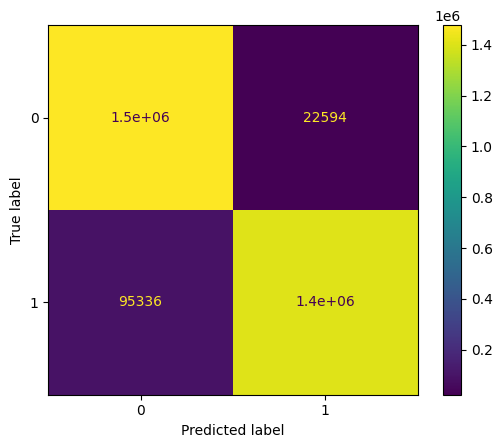

In [12]:
# display matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

cm = confusion_matrix(y_test, predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()